In [1]:
# Load imports
%load_ext autoreload
%autoreload 2
import numpy as np
import enum
import copy
import connect4.connect4 as game
from pympler import asizeof
import deeplearning.buffer as buf
import torch 
import torch.nn as nn
import torch.optim as optim
import deeplearning.mlp as mlp
import torch.nn.functional as F
from deeplearning.league import League
import matplotlib.pyplot as plt

In [2]:
# Instantiate the league
lea = League()

In [37]:
# Play NUM_SEASONS seasons
# Logs are saved to "./data/" by default
# This includes the nn.Module object, the buffers, and elo histories of the agents 
NUM_SEASONS = 5
for _ in range(NUM_SEASONS):
    lea.play_season()

Season 0 training new Agent
100 192.4147890806198 97 1.8755021
200 186.43958568572998 172 1.8239495
300 183.92675030231476 288 1.7858337
400 178.9654369354248 394 1.7386653
500 173.66600692272186 465 1.6803511
600 169.65910410881042 572 1.6375159
700 166.7986524105072 634 1.5950391
800 163.60183334350586 795 1.5710642
900 161.64308273792267 795 1.5710642
1000 160.07535791397095 957 1.541246
1100 158.55569446086884 1068 1.5285727
1200 158.09211218357086 1160 1.4987541
1300 156.8567692041397 1248 1.4672718
1400 156.763565659523 1248 1.4672718
Random Play
0  vs  2
p1:  0.344 p2:  0.654 draw:  0.002
0  vs  1
p1:  0.324 p2:  0.674 draw:  0.002
1  vs  0
p1:  0.654 p2:  0.343 draw:  0.003
2  vs  1
p1:  0.533 p2:  0.466 draw:  0.001
0  vs  1
p1:  0.323 p2:  0.676 draw:  0.001
1  vs  0
p1:  0.682 p2:  0.316 draw:  0.002
2  vs  0
p1:  0.66 p2:  0.339 draw:  0.001
2  vs  1
p1:  0.561 p2:  0.436 draw:  0.003
1  vs  2
p1:  0.46 p2:  0.538 draw:  0.002
0  vs  1
p1:  0.336 p2:  0.663 draw:  0.001
2  

In [6]:
from deeplearning.league import load_elo_history
# Load elo history from log file
elo_path = "data/elo_history.json"  # TODO: change this to your path
elo_history = load_elo_history(elo_path)
elo_history

[{'0': {'0': [913.0], '1': [1034.0], '2': [1053.0]}},
 {'1': {'0': [913.0, 902.0],
   '1': [1034.0, 1025.0],
   '2': [1053.0, 1042.0],
   '3': [0, 1031.0]}},
 {'2': {'0': [913.0, 902.0, 899.0],
   '1': [1034.0, 1025.0, 1009.0],
   '2': [1053.0, 1042.0, 1047.0],
   '3': [0, 1031.0, 1023.0],
   '4': [0, 0, 1022.0]}},
 {'3': {'0': [913.0, 902.0, 899.0, 894.0],
   '1': [1034.0, 1025.0, 1009.0, 1011.0],
   '2': [1053.0, 1042.0, 1047.0, 1033.0],
   '3': [0, 1031.0, 1023.0, 1018.0],
   '4': [0, 0, 1022.0, 1008.0],
   '5': [0, 0, 0, 1036.0]}},
 {'4': {'0': [913.0, 902.0, 899.0, 894.0, 891.0],
   '1': [1034.0, 1025.0, 1009.0, 1011.0, 998.0],
   '2': [1053.0, 1042.0, 1047.0, 1033.0, 1025.0],
   '3': [0, 1031.0, 1023.0, 1018.0, 1006.0],
   '4': [0, 0, 1022.0, 1008.0, 1010.0],
   '5': [0, 0, 0, 1036.0, 1042.0],
   '6': [0, 0, 0, 0, 1028.0]}}]

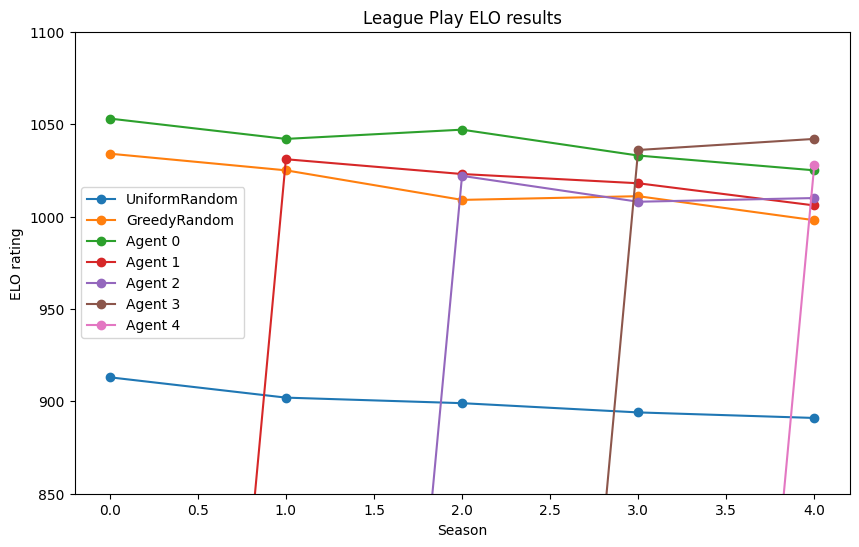

In [28]:
import matplotlib.pyplot as plt

# Take most up to date elo history
num_seasons = len(elo_history)
data = elo_history[-1][str(num_seasons-1)]  # JSON converts int keys to strings

plt.figure(figsize=(10,6))
# Iterate through the dictionary entries and create separate plots
for key, values in data.items():
    key = int(key)
    name = f'Agent {key-2}'
    if key == 0:
        name = f'UniformRandom'
    elif key == 1:
        name = f'GreedyRandom'
    plt.plot([x for x in range(0, len(values))], values, marker='o', label=f'{name}')

# Add labels and title
plt.xlabel('Season')
plt.ylabel('ELO rating')
plt.title('League Play ELO results')
plt.ylim(850, 1100)
plt.legend()  # Add legend to differentiate between entries

# Show the plots
plt.show()

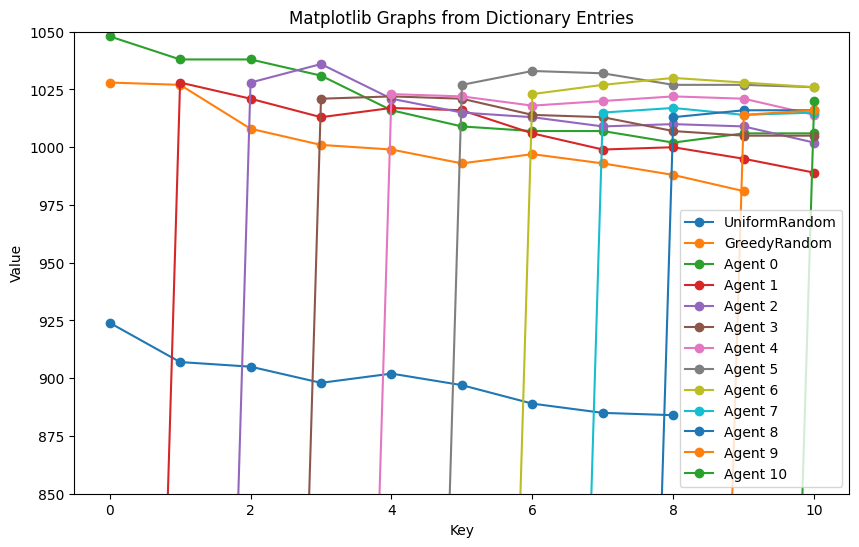

In [8]:
# Previous longer run
elo_history = {0: [924.0, 907.0, 905.0, 898.0, 902.0, 897.0, 889.0, 885.0, 884.0], 1: [1028.0, 1027.0, 1008.0, 1001.0, 999.0, 993.0, 997.0, 993.0, 988.0, 981.0], 2: [1048.0, 1038.0, 1038.0, 1031.0, 1016.0, 1009.0, 1007.0, 1007.0, 1002.0, 1006.0, 1006.0], 3: [0, 1028.0, 1021.0, 1013.0, 1017.0, 1016.0, 1006.0, 999.0, 1000.0, 995.0, 989.0], 4: [0, 0, 1028.0, 1036.0, 1021.0, 1015.0, 1013.0, 1009.0, 1010.0, 1009.0, 1002.0], 5: [0, 0, 0, 1021.0, 1022.0, 1021.0, 1014.0, 1013.0, 1007.0, 1005.0, 1005.0], 6: [0, 0, 0, 0, 1023.0, 1022.0, 1018.0, 1020.0, 1022.0, 1021.0, 1014.0], 7: [0, 0, 0, 0, 0, 1027.0, 1033.0, 1032.0, 1027.0, 1027.0, 1026.0], 8: [0, 0, 0, 0, 0, 0, 1023.0, 1027.0, 1030.0, 1028.0, 1026.0], 9: [0, 0, 0, 0, 0, 0, 0, 1015.0, 1017.0, 1014.0, 1015.0], 10: [0, 0, 0, 0, 0, 0, 0, 0, 1013.0, 1016.0, 1016.0], 11: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1014.0, 1016.0], 12: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1020.0]}
data = elo_history

plt.figure(figsize=(10,6))
# Iterate through the dictionary entries and create separate plots
for key, values in data.items():
    name = f'Agent {key-2}'
    if key == 0:
        name = f'UniformRandom'
    elif key == 1:
        name = f'GreedyRandom'
    plt.plot([x for x in range(0, len(values))], values, marker='o', label=f'{name}')

# Add labels and title
plt.xlabel('Key')
plt.ylabel('Value')
plt.title('League Play ELO results')
plt.ylim(850, 1050)
plt.legend()  # Add legend to differentiate between entries

# Show the plots
plt.show()